<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[16:10:13] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


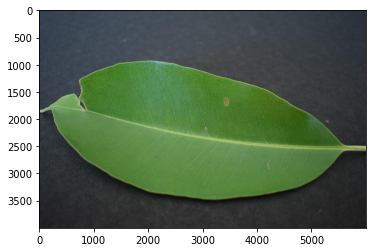

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

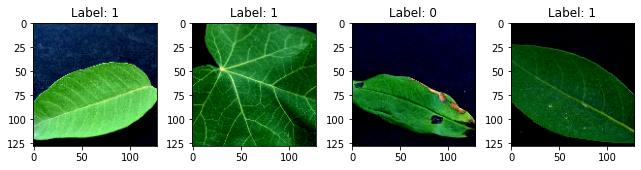

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[16:10:20] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[16:10:22] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2562782966921675 samples/sec                   batch loss = 0.6750794649124146 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2551442709053793 samples/sec                   batch loss = 1.1727548837661743 | accuracy = 0.375


Epoch[1] Batch[15] Speed: 1.2706526489968168 samples/sec                   batch loss = 1.67438805103302 | accuracy = 0.43333333333333335


Epoch[1] Batch[20] Speed: 1.266690816809889 samples/sec                   batch loss = 0.8207807540893555 | accuracy = 0.475


Epoch[1] Batch[25] Speed: 1.2696145429647028 samples/sec                   batch loss = 1.177990436553955 | accuracy = 0.51


Epoch[1] Batch[30] Speed: 1.2579026338763957 samples/sec                   batch loss = 0.6429194211959839 | accuracy = 0.55


Epoch[1] Batch[35] Speed: 1.2646815409754333 samples/sec                   batch loss = 0.3569227457046509 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.2711939135622 samples/sec                   batch loss = 0.3545672595500946 | accuracy = 0.55625


Epoch[1] Batch[45] Speed: 1.2691404791142198 samples/sec                   batch loss = 1.6569737195968628 | accuracy = 0.5611111111111111


Epoch[1] Batch[50] Speed: 1.2651679253707584 samples/sec                   batch loss = 0.5172416567802429 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.2679686537576418 samples/sec                   batch loss = 0.31735995411872864 | accuracy = 0.5818181818181818


Epoch[1] Batch[60] Speed: 1.2637188408283868 samples/sec                   batch loss = 0.33312147855758667 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.2685319953720386 samples/sec                   batch loss = 0.8960341215133667 | accuracy = 0.573076923076923


Epoch[1] Batch[70] Speed: 1.26583831792723 samples/sec                   batch loss = 0.6020397543907166 | accuracy = 0.5821428571428572


Epoch[1] Batch[75] Speed: 1.2645072965812163 samples/sec                   batch loss = 0.6142110824584961 | accuracy = 0.58


Epoch[1] Batch[80] Speed: 1.2613797513902667 samples/sec                   batch loss = 0.2909746468067169 | accuracy = 0.584375


Epoch[1] Batch[85] Speed: 1.2680011406346092 samples/sec                   batch loss = 0.3102104067802429 | accuracy = 0.6029411764705882


Epoch[1] Batch[90] Speed: 1.270211467763944 samples/sec                   batch loss = 0.8558728694915771 | accuracy = 0.6111111111111112


Epoch[1] Batch[95] Speed: 1.2689133689802363 samples/sec                   batch loss = 1.122300148010254 | accuracy = 0.6026315789473684


Epoch[1] Batch[100] Speed: 1.263735403712579 samples/sec                   batch loss = 0.7934165000915527 | accuracy = 0.595


Epoch[1] Batch[105] Speed: 1.2650758651184233 samples/sec                   batch loss = 0.8182117938995361 | accuracy = 0.5976190476190476


Epoch[1] Batch[110] Speed: 1.2673861850565482 samples/sec                   batch loss = 0.3156759738922119 | accuracy = 0.6022727272727273


Epoch[1] Batch[115] Speed: 1.2634209734218116 samples/sec                   batch loss = 0.701187014579773 | accuracy = 0.6021739130434782


Epoch[1] Batch[120] Speed: 1.266867002802068 samples/sec                   batch loss = 1.0308995246887207 | accuracy = 0.6


Epoch[1] Batch[125] Speed: 1.2609665928199862 samples/sec                   batch loss = 0.5411231517791748 | accuracy = 0.604


Epoch[1] Batch[130] Speed: 1.2677838264845904 samples/sec                   batch loss = 0.4145035743713379 | accuracy = 0.6096153846153847


Epoch[1] Batch[135] Speed: 1.2650007958461882 samples/sec                   batch loss = 1.2556077241897583 | accuracy = 0.6092592592592593


Epoch[1] Batch[140] Speed: 1.2615453562464376 samples/sec                   batch loss = 0.6593925356864929 | accuracy = 0.6053571428571428


Epoch[1] Batch[145] Speed: 1.2666581101465733 samples/sec                   batch loss = 0.45200780034065247 | accuracy = 0.6120689655172413


Epoch[1] Batch[150] Speed: 1.2610088632516367 samples/sec                   batch loss = 0.5303178429603577 | accuracy = 0.6133333333333333


Epoch[1] Batch[155] Speed: 1.2587035827613022 samples/sec                   batch loss = 0.38976210355758667 | accuracy = 0.614516129032258


Epoch[1] Batch[160] Speed: 1.2663407902085198 samples/sec                   batch loss = 0.5844979882240295 | accuracy = 0.6171875


Epoch[1] Batch[165] Speed: 1.2676203150899201 samples/sec                   batch loss = 0.5118069052696228 | accuracy = 0.6227272727272727


Epoch[1] Batch[170] Speed: 1.268744193095283 samples/sec                   batch loss = 0.7600623965263367 | accuracy = 0.6176470588235294


Epoch[1] Batch[175] Speed: 1.2579474344148602 samples/sec                   batch loss = 0.4518032968044281 | accuracy = 0.6185714285714285


Epoch[1] Batch[180] Speed: 1.2722315178276569 samples/sec                   batch loss = 0.8547662496566772 | accuracy = 0.6208333333333333


Epoch[1] Batch[185] Speed: 1.2632637218250338 samples/sec                   batch loss = 0.615986168384552 | accuracy = 0.6202702702702703


Epoch[1] Batch[190] Speed: 1.2616632789873314 samples/sec                   batch loss = 0.8291115164756775 | accuracy = 0.6171052631578947


Epoch[1] Batch[195] Speed: 1.261659483865563 samples/sec                   batch loss = 0.4431501030921936 | accuracy = 0.617948717948718


Epoch[1] Batch[200] Speed: 1.2621227522512843 samples/sec                   batch loss = 0.5434637069702148 | accuracy = 0.6225


Epoch[1] Batch[205] Speed: 1.2637784311647349 samples/sec                   batch loss = 0.8402097821235657 | accuracy = 0.624390243902439


Epoch[1] Batch[210] Speed: 1.258332662061215 samples/sec                   batch loss = 0.49016833305358887 | accuracy = 0.6261904761904762


Epoch[1] Batch[215] Speed: 1.2644649818856815 samples/sec                   batch loss = 0.39744290709495544 | accuracy = 0.6302325581395349


Epoch[1] Batch[220] Speed: 1.2597568325929596 samples/sec                   batch loss = 0.44370436668395996 | accuracy = 0.6306818181818182


Epoch[1] Batch[225] Speed: 1.266675037068473 samples/sec                   batch loss = 0.49378421902656555 | accuracy = 0.6322222222222222


Epoch[1] Batch[230] Speed: 1.2623761228960795 samples/sec                   batch loss = 0.43295782804489136 | accuracy = 0.6347826086956522


Epoch[1] Batch[235] Speed: 1.264642837032927 samples/sec                   batch loss = 0.7925185561180115 | accuracy = 0.6393617021276595


Epoch[1] Batch[240] Speed: 1.264355015043272 samples/sec                   batch loss = 0.3557283878326416 | accuracy = 0.6395833333333333


Epoch[1] Batch[245] Speed: 1.2632823654618215 samples/sec                   batch loss = 0.3206651210784912 | accuracy = 0.6418367346938776


Epoch[1] Batch[250] Speed: 1.2599081030640673 samples/sec                   batch loss = 1.0025012493133545 | accuracy = 0.643


Epoch[1] Batch[255] Speed: 1.2600455929802463 samples/sec                   batch loss = 0.7304982542991638 | accuracy = 0.6431372549019608


Epoch[1] Batch[260] Speed: 1.2651697380905376 samples/sec                   batch loss = 0.6442273855209351 | accuracy = 0.6461538461538462


Epoch[1] Batch[265] Speed: 1.2650640365858716 samples/sec                   batch loss = 0.5309337377548218 | accuracy = 0.6443396226415095


Epoch[1] Batch[270] Speed: 1.2661015907983968 samples/sec                   batch loss = 0.5375749468803406 | accuracy = 0.6453703703703704


Epoch[1] Batch[275] Speed: 1.2706720887976062 samples/sec                   batch loss = 0.7790688276290894 | accuracy = 0.6418181818181818


Epoch[1] Batch[280] Speed: 1.2623628250559353 samples/sec                   batch loss = 0.3194819390773773 | accuracy = 0.6446428571428572


Epoch[1] Batch[285] Speed: 1.266905268995481 samples/sec                   batch loss = 0.2440367043018341 | accuracy = 0.6464912280701754


Epoch[1] Batch[290] Speed: 1.2643633047711635 samples/sec                   batch loss = 0.5259767770767212 | accuracy = 0.6482758620689655


Epoch[1] Batch[295] Speed: 1.2601428854594663 samples/sec                   batch loss = 1.1956713199615479 | accuracy = 0.6474576271186441


Epoch[1] Batch[300] Speed: 1.260994930755907 samples/sec                   batch loss = 0.5580952763557434 | accuracy = 0.645


Epoch[1] Batch[305] Speed: 1.2623599755552108 samples/sec                   batch loss = 1.0070970058441162 | accuracy = 0.6434426229508197


Epoch[1] Batch[310] Speed: 1.267931281533499 samples/sec                   batch loss = 1.2392425537109375 | accuracy = 0.6427419354838709


Epoch[1] Batch[315] Speed: 1.2748303388845525 samples/sec                   batch loss = 0.49939635396003723 | accuracy = 0.6420634920634921


Epoch[1] Batch[320] Speed: 1.2653443559746382 samples/sec                   batch loss = 0.49673888087272644 | accuracy = 0.64609375


Epoch[1] Batch[325] Speed: 1.265434164593024 samples/sec                   batch loss = 0.6162759065628052 | accuracy = 0.6461538461538462


Epoch[1] Batch[330] Speed: 1.2679378933819814 samples/sec                   batch loss = 0.7626501321792603 | accuracy = 0.646969696969697


Epoch[1] Batch[335] Speed: 1.2661228981456976 samples/sec                   batch loss = 0.30000853538513184 | accuracy = 0.6492537313432836


Epoch[1] Batch[340] Speed: 1.263801088390136 samples/sec                   batch loss = 0.4468275010585785 | accuracy = 0.6463235294117647


Epoch[1] Batch[345] Speed: 1.2672345494282713 samples/sec                   batch loss = 0.5074425935745239 | accuracy = 0.6463768115942029


Epoch[1] Batch[350] Speed: 1.266129108942453 samples/sec                   batch loss = 0.8104746341705322 | accuracy = 0.6464285714285715


Epoch[1] Batch[355] Speed: 1.2640842770268657 samples/sec                   batch loss = 0.5177271962165833 | accuracy = 0.645774647887324


Epoch[1] Batch[360] Speed: 1.2616836781580152 samples/sec                   batch loss = 0.42943501472473145 | accuracy = 0.6465277777777778


Epoch[1] Batch[365] Speed: 1.2603145089126082 samples/sec                   batch loss = 0.46758267283439636 | accuracy = 0.6458904109589041


Epoch[1] Batch[370] Speed: 1.2654872349757855 samples/sec                   batch loss = 0.6400604248046875 | accuracy = 0.6472972972972973


Epoch[1] Batch[375] Speed: 1.2704972482127543 samples/sec                   batch loss = 0.5792482495307922 | accuracy = 0.6473333333333333


Epoch[1] Batch[380] Speed: 1.2669104351086968 samples/sec                   batch loss = 0.6454681754112244 | accuracy = 0.6447368421052632


Epoch[1] Batch[385] Speed: 1.2648621271288814 samples/sec                   batch loss = 0.39802849292755127 | accuracy = 0.6461038961038961


Epoch[1] Batch[390] Speed: 1.269637506018157 samples/sec                   batch loss = 0.6860817074775696 | accuracy = 0.6467948717948718


Epoch[1] Batch[395] Speed: 1.267556626987374 samples/sec                   batch loss = 0.45090049505233765 | accuracy = 0.6474683544303798


Epoch[1] Batch[400] Speed: 1.2607292297026298 samples/sec                   batch loss = 0.5735129714012146 | accuracy = 0.6475


Epoch[1] Batch[405] Speed: 1.268671182161429 samples/sec                   batch loss = 0.46792641282081604 | accuracy = 0.6493827160493827


Epoch[1] Batch[410] Speed: 1.266367554053543 samples/sec                   batch loss = 0.43953970074653625 | accuracy = 0.650609756097561


Epoch[1] Batch[415] Speed: 1.264824174966725 samples/sec                   batch loss = 1.2085115909576416 | accuracy = 0.6512048192771084


Epoch[1] Batch[420] Speed: 1.2647615302746555 samples/sec                   batch loss = 0.44668200612068176 | accuracy = 0.6523809523809524


Epoch[1] Batch[425] Speed: 1.2750566650777746 samples/sec                   batch loss = 0.47873160243034363 | accuracy = 0.6523529411764706


Epoch[1] Batch[430] Speed: 1.2649862981060134 samples/sec                   batch loss = 0.49777495861053467 | accuracy = 0.6534883720930232


Epoch[1] Batch[435] Speed: 1.2638696362035342 samples/sec                   batch loss = 0.26863041520118713 | accuracy = 0.6545977011494253


Epoch[1] Batch[440] Speed: 1.2571186226047655 samples/sec                   batch loss = 0.9865710735321045 | accuracy = 0.6556818181818181


Epoch[1] Batch[445] Speed: 1.2618196578547507 samples/sec                   batch loss = 0.5091526508331299 | accuracy = 0.6567415730337078


Epoch[1] Batch[450] Speed: 1.2672077489243374 samples/sec                   batch loss = 0.36892208456993103 | accuracy = 0.655


Epoch[1] Batch[455] Speed: 1.2672546505501727 samples/sec                   batch loss = 0.6955500841140747 | accuracy = 0.6554945054945055


Epoch[1] Batch[460] Speed: 1.2662796199534478 samples/sec                   batch loss = 0.22191357612609863 | accuracy = 0.6565217391304348


Epoch[1] Batch[465] Speed: 1.2643263353290597 samples/sec                   batch loss = 0.3426518440246582 | accuracy = 0.6559139784946236


Epoch[1] Batch[470] Speed: 1.2661340776237286 samples/sec                   batch loss = 1.1078009605407715 | accuracy = 0.6547872340425532


Epoch[1] Batch[475] Speed: 1.270416146988065 samples/sec                   batch loss = 1.2104765176773071 | accuracy = 0.6552631578947369


Epoch[1] Batch[480] Speed: 1.2639305738360775 samples/sec                   batch loss = 1.0398502349853516 | accuracy = 0.65625


Epoch[1] Batch[485] Speed: 1.2633402022854439 samples/sec                   batch loss = 0.5927650332450867 | accuracy = 0.6577319587628866


Epoch[1] Batch[490] Speed: 1.2661339820717978 samples/sec                   batch loss = 0.7004499435424805 | accuracy = 0.6581632653061225


Epoch[1] Batch[495] Speed: 1.261168966877846 samples/sec                   batch loss = 0.2416624277830124 | accuracy = 0.6601010101010101


Epoch[1] Batch[500] Speed: 1.263172033579148 samples/sec                   batch loss = 0.8448976278305054 | accuracy = 0.659


Epoch[1] Batch[505] Speed: 1.2691574724476018 samples/sec                   batch loss = 1.949864387512207 | accuracy = 0.6594059405940594


Epoch[1] Batch[510] Speed: 1.2661384730281338 samples/sec                   batch loss = 0.452926367521286 | accuracy = 0.6607843137254902


Epoch[1] Batch[515] Speed: 1.2652251716614025 samples/sec                   batch loss = 0.4496174454689026 | accuracy = 0.6611650485436893


Epoch[1] Batch[520] Speed: 1.2632165444677068 samples/sec                   batch loss = 0.2848396301269531 | accuracy = 0.6625


Epoch[1] Batch[525] Speed: 1.2658466271171083 samples/sec                   batch loss = 0.3710448741912842 | accuracy = 0.6619047619047619


Epoch[1] Batch[530] Speed: 1.268024045362585 samples/sec                   batch loss = 0.5612512230873108 | accuracy = 0.6622641509433962


Epoch[1] Batch[535] Speed: 1.2622526537284613 samples/sec                   batch loss = 0.6510547995567322 | accuracy = 0.6635514018691588


Epoch[1] Batch[540] Speed: 1.2674841356877296 samples/sec                   batch loss = 0.38376757502555847 | accuracy = 0.6638888888888889


Epoch[1] Batch[545] Speed: 1.26221162932067 samples/sec                   batch loss = 0.638222336769104 | accuracy = 0.6637614678899083


Epoch[1] Batch[550] Speed: 1.2656426537130259 samples/sec                   batch loss = 1.0203300714492798 | accuracy = 0.665


Epoch[1] Batch[555] Speed: 1.2647663928824806 samples/sec                   batch loss = 0.4579213261604309 | accuracy = 0.6653153153153153


Epoch[1] Batch[560] Speed: 1.2630299621148586 samples/sec                   batch loss = 0.47127243876457214 | accuracy = 0.6651785714285714


Epoch[1] Batch[565] Speed: 1.2633444831818914 samples/sec                   batch loss = 1.0381234884262085 | accuracy = 0.6646017699115044


Epoch[1] Batch[570] Speed: 1.2662997863689116 samples/sec                   batch loss = 0.3400186598300934 | accuracy = 0.6666666666666666


Epoch[1] Batch[575] Speed: 1.2619347843027173 samples/sec                   batch loss = 0.7123943567276001 | accuracy = 0.6678260869565218


Epoch[1] Batch[580] Speed: 1.2615248666907886 samples/sec                   batch loss = 0.9218183159828186 | accuracy = 0.6685344827586207


Epoch[1] Batch[585] Speed: 1.260036508068238 samples/sec                   batch loss = 0.40379250049591064 | accuracy = 0.67008547008547


Epoch[1] Batch[590] Speed: 1.265278224515553 samples/sec                   batch loss = 1.4831174612045288 | accuracy = 0.6707627118644067


Epoch[1] Batch[595] Speed: 1.2641707634078023 samples/sec                   batch loss = 0.35280299186706543 | accuracy = 0.6710084033613445


Epoch[1] Batch[600] Speed: 1.2647951879146935 samples/sec                   batch loss = 0.32337063550949097 | accuracy = 0.6729166666666667


Epoch[1] Batch[605] Speed: 1.2637899500727665 samples/sec                   batch loss = 0.5759196877479553 | accuracy = 0.6727272727272727


Epoch[1] Batch[610] Speed: 1.2669410499775644 samples/sec                   batch loss = 0.21330894529819489 | accuracy = 0.6737704918032786


Epoch[1] Batch[615] Speed: 1.260881870936119 samples/sec                   batch loss = 0.46781161427497864 | accuracy = 0.6743902439024391


Epoch[1] Batch[620] Speed: 1.2659544654635135 samples/sec                   batch loss = 0.5106794238090515 | accuracy = 0.675


Epoch[1] Batch[625] Speed: 1.2622399282796335 samples/sec                   batch loss = 0.3317981958389282 | accuracy = 0.6768


Epoch[1] Batch[630] Speed: 1.26418867175847 samples/sec                   batch loss = 0.7549272775650024 | accuracy = 0.6777777777777778


Epoch[1] Batch[635] Speed: 1.257433504606508 samples/sec                   batch loss = 0.5082833766937256 | accuracy = 0.6771653543307087


Epoch[1] Batch[640] Speed: 1.2645308377391984 samples/sec                   batch loss = 0.7133582234382629 | accuracy = 0.67734375


Epoch[1] Batch[645] Speed: 1.2702964862750763 samples/sec                   batch loss = 0.5291287899017334 | accuracy = 0.6775193798449612


Epoch[1] Batch[650] Speed: 1.2603416813899955 samples/sec                   batch loss = 0.22895435988903046 | accuracy = 0.6788461538461539


Epoch[1] Batch[655] Speed: 1.2650570731177286 samples/sec                   batch loss = 0.2942008972167969 | accuracy = 0.6793893129770993


Epoch[1] Batch[660] Speed: 1.2634817726442886 samples/sec                   batch loss = 0.28414440155029297 | accuracy = 0.6791666666666667


Epoch[1] Batch[665] Speed: 1.2688117428879166 samples/sec                   batch loss = 0.9306809306144714 | accuracy = 0.6800751879699248


Epoch[1] Batch[670] Speed: 1.262698206144174 samples/sec                   batch loss = 0.6914777159690857 | accuracy = 0.6794776119402985


Epoch[1] Batch[675] Speed: 1.2649112394628528 samples/sec                   batch loss = 0.3403517007827759 | accuracy = 0.6803703703703704


Epoch[1] Batch[680] Speed: 1.2633987103814914 samples/sec                   batch loss = 0.18100254237651825 | accuracy = 0.680514705882353


Epoch[1] Batch[685] Speed: 1.2627347953130765 samples/sec                   batch loss = 0.6059346199035645 | accuracy = 0.6817518248175183


Epoch[1] Batch[690] Speed: 1.2647730671109636 samples/sec                   batch loss = 0.36366888880729675 | accuracy = 0.6822463768115942


Epoch[1] Batch[695] Speed: 1.2734189716870015 samples/sec                   batch loss = 0.5096290707588196 | accuracy = 0.6820143884892086


Epoch[1] Batch[700] Speed: 1.2631992343049685 samples/sec                   batch loss = 1.0644176006317139 | accuracy = 0.6825


Epoch[1] Batch[705] Speed: 1.261800677770099 samples/sec                   batch loss = 0.6539494395256042 | accuracy = 0.6833333333333333


Epoch[1] Batch[710] Speed: 1.2628605451675525 samples/sec                   batch loss = 0.5400775074958801 | accuracy = 0.6841549295774648


Epoch[1] Batch[715] Speed: 1.269202310149955 samples/sec                   batch loss = 0.5650428533554077 | accuracy = 0.6846153846153846


Epoch[1] Batch[720] Speed: 1.263286836211628 samples/sec                   batch loss = 0.9905229210853577 | accuracy = 0.6847222222222222


Epoch[1] Batch[725] Speed: 1.2582923639204366 samples/sec                   batch loss = 0.5955188274383545 | accuracy = 0.6841379310344827


Epoch[1] Batch[730] Speed: 1.2660809529753236 samples/sec                   batch loss = 0.8853185176849365 | accuracy = 0.6832191780821918


Epoch[1] Batch[735] Speed: 1.264976283413771 samples/sec                   batch loss = 0.3952053487300873 | accuracy = 0.6833333333333333


Epoch[1] Batch[740] Speed: 1.2621331965569793 samples/sec                   batch loss = 0.38577455282211304 | accuracy = 0.6841216216216216


Epoch[1] Batch[745] Speed: 1.2636496431292072 samples/sec                   batch loss = 0.709414005279541 | accuracy = 0.6848993288590604


Epoch[1] Batch[750] Speed: 1.2655573977994656 samples/sec                   batch loss = 0.4002394378185272 | accuracy = 0.6846666666666666


Epoch[1] Batch[755] Speed: 1.256435507577084 samples/sec                   batch loss = 0.25208011269569397 | accuracy = 0.6854304635761589


Epoch[1] Batch[760] Speed: 1.2637649133751792 samples/sec                   batch loss = 0.5604197382926941 | accuracy = 0.6848684210526316


Epoch[1] Batch[765] Speed: 1.2622806696133297 samples/sec                   batch loss = 0.4748370051383972 | accuracy = 0.6852941176470588


Epoch[1] Batch[770] Speed: 1.2686168851285489 samples/sec                   batch loss = 0.5469337105751038 | accuracy = 0.685064935064935


Epoch[1] Batch[775] Speed: 1.266386480598238 samples/sec                   batch loss = 0.23481442034244537 | accuracy = 0.6864516129032258


Epoch[1] Batch[780] Speed: 1.2700909802520315 samples/sec                   batch loss = 0.5665125250816345 | accuracy = 0.6868589743589744


Epoch[1] Batch[785] Speed: 1.2653635382539203 samples/sec                   batch loss = 0.38501131534576416 | accuracy = 0.6869426751592357


[Epoch 1] training: accuracy=0.686230964467005
[Epoch 1] time cost: 650.4455618858337
[Epoch 1] validation: validation accuracy=0.7722222222222223


Epoch[2] Batch[5] Speed: 1.2649386105155858 samples/sec                   batch loss = 0.287541925907135 | accuracy = 0.9


Epoch[2] Batch[10] Speed: 1.2669593239325663 samples/sec                   batch loss = 0.664620578289032 | accuracy = 0.85


Epoch[2] Batch[15] Speed: 1.2666836441514162 samples/sec                   batch loss = 0.4932209551334381 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.26328559961809 samples/sec                   batch loss = 0.2815130949020386 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.263279987416306 samples/sec                   batch loss = 0.24661870300769806 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.2717762248448978 samples/sec                   batch loss = 0.6447866559028625 | accuracy = 0.775


Epoch[2] Batch[35] Speed: 1.2638355517779836 samples/sec                   batch loss = 0.45518869161605835 | accuracy = 0.7714285714285715


Epoch[2] Batch[40] Speed: 1.2608859456654362 samples/sec                   batch loss = 0.657932460308075 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.266261939027597 samples/sec                   batch loss = 0.42304757237434387 | accuracy = 0.7555555555555555


Epoch[2] Batch[50] Speed: 1.2642617392768218 samples/sec                   batch loss = 0.4563118815422058 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.264858884895403 samples/sec                   batch loss = 0.7030424475669861 | accuracy = 0.7545454545454545


Epoch[2] Batch[60] Speed: 1.2635280182243325 samples/sec                   batch loss = 0.6009784936904907 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.262997729463904 samples/sec                   batch loss = 0.23469345271587372 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.2664338950323473 samples/sec                   batch loss = 1.0973349809646606 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.269364213106083 samples/sec                   batch loss = 0.34159544110298157 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.2694392248568087 samples/sec                   batch loss = 0.44191187620162964 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.2706275321151765 samples/sec                   batch loss = 0.25897520780563354 | accuracy = 0.7558823529411764


Epoch[2] Batch[90] Speed: 1.26815554792957 samples/sec                   batch loss = 0.5255616307258606 | accuracy = 0.7611111111111111


Epoch[2] Batch[95] Speed: 1.2661654194351966 samples/sec                   batch loss = 0.46642932295799255 | accuracy = 0.7631578947368421


Epoch[2] Batch[100] Speed: 1.267184490834349 samples/sec                   batch loss = 0.4347015619277954 | accuracy = 0.7675


Epoch[2] Batch[105] Speed: 1.266753078898213 samples/sec                   batch loss = 0.25831338763237 | accuracy = 0.7714285714285715


Epoch[2] Batch[110] Speed: 1.2690040688994457 samples/sec                   batch loss = 0.18753619492053986 | accuracy = 0.775


Epoch[2] Batch[115] Speed: 1.2726055628159711 samples/sec                   batch loss = 0.19964653253555298 | accuracy = 0.7739130434782608


Epoch[2] Batch[120] Speed: 1.2674609632035367 samples/sec                   batch loss = 0.14958317577838898 | accuracy = 0.7791666666666667


Epoch[2] Batch[125] Speed: 1.2652357627930302 samples/sec                   batch loss = 0.5911397337913513 | accuracy = 0.774


Epoch[2] Batch[130] Speed: 1.2757365141094932 samples/sec                   batch loss = 0.6900773644447327 | accuracy = 0.7711538461538462


Epoch[2] Batch[135] Speed: 1.272309763435485 samples/sec                   batch loss = 0.6934202909469604 | accuracy = 0.7685185185185185


Epoch[2] Batch[140] Speed: 1.263658685039105 samples/sec                   batch loss = 0.8449817895889282 | accuracy = 0.7678571428571429


Epoch[2] Batch[145] Speed: 1.2687991727085166 samples/sec                   batch loss = 0.5764697790145874 | accuracy = 0.7689655172413793


Epoch[2] Batch[150] Speed: 1.2625743889213366 samples/sec                   batch loss = 0.4476974904537201 | accuracy = 0.7683333333333333


Epoch[2] Batch[155] Speed: 1.2644311512272444 samples/sec                   batch loss = 0.514891505241394 | accuracy = 0.7677419354838709


Epoch[2] Batch[160] Speed: 1.2619417134400968 samples/sec                   batch loss = 0.5761941075325012 | accuracy = 0.7609375


Epoch[2] Batch[165] Speed: 1.2611585385242252 samples/sec                   batch loss = 0.5773484110832214 | accuracy = 0.7621212121212121


Epoch[2] Batch[170] Speed: 1.267594647535857 samples/sec                   batch loss = 0.7182080745697021 | accuracy = 0.7544117647058823


Epoch[2] Batch[175] Speed: 1.270330823900054 samples/sec                   batch loss = 0.677646279335022 | accuracy = 0.7542857142857143


Epoch[2] Batch[180] Speed: 1.2689606848865604 samples/sec                   batch loss = 0.7186065316200256 | accuracy = 0.7513888888888889


Epoch[2] Batch[185] Speed: 1.2673725899778008 samples/sec                   batch loss = 0.4113273024559021 | accuracy = 0.7527027027027027


Epoch[2] Batch[190] Speed: 1.2643233816782404 samples/sec                   batch loss = 0.5169059038162231 | accuracy = 0.7526315789473684


Epoch[2] Batch[195] Speed: 1.2650910326733433 samples/sec                   batch loss = 0.5603798031806946 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.2617957430416173 samples/sec                   batch loss = 0.3233722746372223 | accuracy = 0.75125


Epoch[2] Batch[205] Speed: 1.2601814091045864 samples/sec                   batch loss = 0.589470386505127 | accuracy = 0.7475609756097561


Epoch[2] Batch[210] Speed: 1.2599805819642977 samples/sec                   batch loss = 0.7856565117835999 | accuracy = 0.7464285714285714


Epoch[2] Batch[215] Speed: 1.263442571223521 samples/sec                   batch loss = 1.079575538635254 | accuracy = 0.7453488372093023


Epoch[2] Batch[220] Speed: 1.268778350898267 samples/sec                   batch loss = 0.5845321416854858 | accuracy = 0.7477272727272727


Epoch[2] Batch[225] Speed: 1.2645080590341369 samples/sec                   batch loss = 0.3154292106628418 | accuracy = 0.7488888888888889


Epoch[2] Batch[230] Speed: 1.260016067495196 samples/sec                   batch loss = 0.096051424741745 | accuracy = 0.75


Epoch[2] Batch[235] Speed: 1.263608147181302 samples/sec                   batch loss = 0.31061676144599915 | accuracy = 0.752127659574468


Epoch[2] Batch[240] Speed: 1.2622787701920057 samples/sec                   batch loss = 1.0249390602111816 | accuracy = 0.753125


Epoch[2] Batch[245] Speed: 1.2639856131856029 samples/sec                   batch loss = 0.5767108798027039 | accuracy = 0.7520408163265306


Epoch[2] Batch[250] Speed: 1.2662400535924279 samples/sec                   batch loss = 0.42270368337631226 | accuracy = 0.748


Epoch[2] Batch[255] Speed: 1.2629745305799331 samples/sec                   batch loss = 0.2023201286792755 | accuracy = 0.7450980392156863


Epoch[2] Batch[260] Speed: 1.2663095352929516 samples/sec                   batch loss = 0.24026426672935486 | accuracy = 0.7451923076923077


Epoch[2] Batch[265] Speed: 1.2671732927992145 samples/sec                   batch loss = 0.43565633893013 | accuracy = 0.7462264150943396


Epoch[2] Batch[270] Speed: 1.271495168729185 samples/sec                   batch loss = 0.4408196806907654 | accuracy = 0.7472222222222222


Epoch[2] Batch[275] Speed: 1.2705351567250862 samples/sec                   batch loss = 0.5918341875076294 | accuracy = 0.7454545454545455


Epoch[2] Batch[280] Speed: 1.2715571330465767 samples/sec                   batch loss = 0.5140523910522461 | accuracy = 0.7446428571428572


Epoch[2] Batch[285] Speed: 1.2619259568817554 samples/sec                   batch loss = 0.45209571719169617 | accuracy = 0.7412280701754386


Epoch[2] Batch[290] Speed: 1.2662994040612237 samples/sec                   batch loss = 0.3408849537372589 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.2654285332848598 samples/sec                   batch loss = 0.31771373748779297 | accuracy = 0.7423728813559322


Epoch[2] Batch[300] Speed: 1.2701596351387179 samples/sec                   batch loss = 0.5898706912994385 | accuracy = 0.7416666666666667


Epoch[2] Batch[305] Speed: 1.2684176759367247 samples/sec                   batch loss = 0.37880659103393555 | accuracy = 0.7426229508196721


Epoch[2] Batch[310] Speed: 1.262701817448347 samples/sec                   batch loss = 0.29499441385269165 | accuracy = 0.742741935483871


Epoch[2] Batch[315] Speed: 1.2709729040883484 samples/sec                   batch loss = 0.31883156299591064 | accuracy = 0.7436507936507937


Epoch[2] Batch[320] Speed: 1.2684437604363445 samples/sec                   batch loss = 0.4059481918811798 | accuracy = 0.74453125


Epoch[2] Batch[325] Speed: 1.2655127217956548 samples/sec                   batch loss = 0.6640619039535522 | accuracy = 0.7461538461538462


Epoch[2] Batch[330] Speed: 1.2704123952246982 samples/sec                   batch loss = 0.32338738441467285 | accuracy = 0.7462121212121212


Epoch[2] Batch[335] Speed: 1.2677813356607555 samples/sec                   batch loss = 0.17610645294189453 | accuracy = 0.7477611940298508


Epoch[2] Batch[340] Speed: 1.2625866460284534 samples/sec                   batch loss = 0.7770022749900818 | accuracy = 0.7470588235294118


Epoch[2] Batch[345] Speed: 1.2695603572944978 samples/sec                   batch loss = 0.5767467617988586 | accuracy = 0.7478260869565218


Epoch[2] Batch[350] Speed: 1.2566941302645533 samples/sec                   batch loss = 0.6027826070785522 | accuracy = 0.7485714285714286


Epoch[2] Batch[355] Speed: 1.2633337334303003 samples/sec                   batch loss = 0.43147483468055725 | accuracy = 0.7485915492957746


Epoch[2] Batch[360] Speed: 1.2632837922934281 samples/sec                   batch loss = 0.162257581949234 | accuracy = 0.7479166666666667


Epoch[2] Batch[365] Speed: 1.2637194119550972 samples/sec                   batch loss = 0.25338980555534363 | accuracy = 0.7493150684931507


Epoch[2] Batch[370] Speed: 1.2664064592314008 samples/sec                   batch loss = 0.4900561273097992 | accuracy = 0.7493243243243243


Epoch[2] Batch[375] Speed: 1.2620430963701212 samples/sec                   batch loss = 0.2261274755001068 | accuracy = 0.7486666666666667


Epoch[2] Batch[380] Speed: 1.2619406693186361 samples/sec                   batch loss = 0.4089909791946411 | accuracy = 0.7480263157894737


Epoch[2] Batch[385] Speed: 1.265666141682624 samples/sec                   batch loss = 0.22687169909477234 | accuracy = 0.7474025974025974


Epoch[2] Batch[390] Speed: 1.26346845150029 samples/sec                   batch loss = 0.26062700152397156 | accuracy = 0.7474358974358974


Epoch[2] Batch[395] Speed: 1.2648490629366074 samples/sec                   batch loss = 0.40468746423721313 | accuracy = 0.7462025316455696


Epoch[2] Batch[400] Speed: 1.2686945907966267 samples/sec                   batch loss = 0.38285890221595764 | accuracy = 0.745625


Epoch[2] Batch[405] Speed: 1.2658466271171083 samples/sec                   batch loss = 0.37195584177970886 | accuracy = 0.7462962962962963


Epoch[2] Batch[410] Speed: 1.2629952574111092 samples/sec                   batch loss = 0.0609380342066288 | accuracy = 0.7475609756097561


Epoch[2] Batch[415] Speed: 1.2657805386465504 samples/sec                   batch loss = 0.23152172565460205 | accuracy = 0.7487951807228915


Epoch[2] Batch[420] Speed: 1.2677746296452324 samples/sec                   batch loss = 0.48750221729278564 | accuracy = 0.7488095238095238


Epoch[2] Batch[425] Speed: 1.264931648428171 samples/sec                   batch loss = 0.38837167620658875 | accuracy = 0.7482352941176471


Epoch[2] Batch[430] Speed: 1.2689070348670772 samples/sec                   batch loss = 0.7311181426048279 | accuracy = 0.7476744186046511


Epoch[2] Batch[435] Speed: 1.2674620164798915 samples/sec                   batch loss = 0.5052897930145264 | accuracy = 0.746551724137931


Epoch[2] Batch[440] Speed: 1.2676858295297706 samples/sec                   batch loss = 0.2863662540912628 | accuracy = 0.7460227272727272


Epoch[2] Batch[445] Speed: 1.2660424499466143 samples/sec                   batch loss = 0.2944326102733612 | accuracy = 0.7471910112359551


Epoch[2] Batch[450] Speed: 1.2644975753870755 samples/sec                   batch loss = 1.0184699296951294 | accuracy = 0.7466666666666667


Epoch[2] Batch[455] Speed: 1.2674679531611763 samples/sec                   batch loss = 0.6434934139251709 | accuracy = 0.7456043956043956


Epoch[2] Batch[460] Speed: 1.2689789211677511 samples/sec                   batch loss = 0.4999271631240845 | accuracy = 0.7451086956521739


Epoch[2] Batch[465] Speed: 1.2690341131069485 samples/sec                   batch loss = 0.16527050733566284 | accuracy = 0.7462365591397849


Epoch[2] Batch[470] Speed: 1.265618307347643 samples/sec                   batch loss = 0.4436667561531067 | accuracy = 0.7473404255319149


Epoch[2] Batch[475] Speed: 1.2665392519067107 samples/sec                   batch loss = 0.32404229044914246 | accuracy = 0.7463157894736843


Epoch[2] Batch[480] Speed: 1.2656889621303073 samples/sec                   batch loss = 0.3852066397666931 | accuracy = 0.7463541666666667


Epoch[2] Batch[485] Speed: 1.2682817086755793 samples/sec                   batch loss = 0.19078554213047028 | accuracy = 0.7474226804123711


Epoch[2] Batch[490] Speed: 1.2686371260585767 samples/sec                   batch loss = 0.2419145405292511 | accuracy = 0.7479591836734694


Epoch[2] Batch[495] Speed: 1.270723578272747 samples/sec                   batch loss = 0.3537709712982178 | accuracy = 0.747979797979798


Epoch[2] Batch[500] Speed: 1.269239565297287 samples/sec                   batch loss = 0.45595404505729675 | accuracy = 0.747


Epoch[2] Batch[505] Speed: 1.2763856255433907 samples/sec                   batch loss = 0.5715201497077942 | accuracy = 0.7465346534653465


Epoch[2] Batch[510] Speed: 1.2656531563559044 samples/sec                   batch loss = 0.22593097388744354 | accuracy = 0.746078431372549


Epoch[2] Batch[515] Speed: 1.2656316738636582 samples/sec                   batch loss = 0.20633701980113983 | accuracy = 0.7470873786407767


Epoch[2] Batch[520] Speed: 1.2634610298419071 samples/sec                   batch loss = 0.21257160604000092 | accuracy = 0.7471153846153846


Epoch[2] Batch[525] Speed: 1.2667802427713777 samples/sec                   batch loss = 0.36562642455101013 | accuracy = 0.7480952380952381


Epoch[2] Batch[530] Speed: 1.2684188267008516 samples/sec                   batch loss = 0.39644473791122437 | accuracy = 0.7485849056603774


Epoch[2] Batch[535] Speed: 1.2708833665726753 samples/sec                   batch loss = 0.3763704299926758 | accuracy = 0.7504672897196262


Epoch[2] Batch[540] Speed: 1.267456941619012 samples/sec                   batch loss = 0.7233722805976868 | accuracy = 0.75


Epoch[2] Batch[545] Speed: 1.2697653072221826 samples/sec                   batch loss = 0.5387532114982605 | accuracy = 0.7495412844036697


Epoch[2] Batch[550] Speed: 1.2707997133484819 samples/sec                   batch loss = 0.16074882447719574 | accuracy = 0.7513636363636363


Epoch[2] Batch[555] Speed: 1.2641798127769055 samples/sec                   batch loss = 0.5236835479736328 | accuracy = 0.75


Epoch[2] Batch[560] Speed: 1.2670366352918592 samples/sec                   batch loss = 0.4330928921699524 | accuracy = 0.7495535714285714


Epoch[2] Batch[565] Speed: 1.266602550944104 samples/sec                   batch loss = 0.4178241491317749 | accuracy = 0.75


Epoch[2] Batch[570] Speed: 1.2689156723097907 samples/sec                   batch loss = 0.45886874198913574 | accuracy = 0.750438596491228


Epoch[2] Batch[575] Speed: 1.262773002370689 samples/sec                   batch loss = 0.1206856518983841 | accuracy = 0.7504347826086957


Epoch[2] Batch[580] Speed: 1.2630633374782438 samples/sec                   batch loss = 0.4350234866142273 | accuracy = 0.7508620689655172


Epoch[2] Batch[585] Speed: 1.2631093622399985 samples/sec                   batch loss = 0.6261498928070068 | accuracy = 0.7495726495726496


Epoch[2] Batch[590] Speed: 1.2637894740806723 samples/sec                   batch loss = 0.49171605706214905 | accuracy = 0.7487288135593221


Epoch[2] Batch[595] Speed: 1.2647760228632254 samples/sec                   batch loss = 0.4106253981590271 | accuracy = 0.7491596638655462


Epoch[2] Batch[600] Speed: 1.2702787891764888 samples/sec                   batch loss = 0.5880758762359619 | accuracy = 0.74875


Epoch[2] Batch[605] Speed: 1.2633082391756503 samples/sec                   batch loss = 0.3279836177825928 | accuracy = 0.7491735537190083


Epoch[2] Batch[610] Speed: 1.2613030339822704 samples/sec                   batch loss = 1.4242730140686035 | accuracy = 0.7495901639344262


Epoch[2] Batch[615] Speed: 1.2684697501040159 samples/sec                   batch loss = 0.6319351196289062 | accuracy = 0.7491869918699187


Epoch[2] Batch[620] Speed: 1.2680321915950281 samples/sec                   batch loss = 0.5119081139564514 | accuracy = 0.7495967741935484


Epoch[2] Batch[625] Speed: 1.267619644655511 samples/sec                   batch loss = 0.3392277657985687 | accuracy = 0.75


Epoch[2] Batch[630] Speed: 1.2690137635202081 samples/sec                   batch loss = 0.5089880228042603 | accuracy = 0.75


Epoch[2] Batch[635] Speed: 1.2694542090600802 samples/sec                   batch loss = 0.4362211525440216 | accuracy = 0.7511811023622047


Epoch[2] Batch[640] Speed: 1.2664508159621626 samples/sec                   batch loss = 0.3051016926765442 | accuracy = 0.751171875


Epoch[2] Batch[645] Speed: 1.269461221020288 samples/sec                   batch loss = 0.5684967637062073 | accuracy = 0.751937984496124


Epoch[2] Batch[650] Speed: 1.2681319674741982 samples/sec                   batch loss = 0.3411800265312195 | accuracy = 0.7519230769230769


Epoch[2] Batch[655] Speed: 1.2674138548148792 samples/sec                   batch loss = 0.5523744225502014 | accuracy = 0.7519083969465649


Epoch[2] Batch[660] Speed: 1.2711807182468797 samples/sec                   batch loss = 1.4600038528442383 | accuracy = 0.7503787878787879


Epoch[2] Batch[665] Speed: 1.2663436577092329 samples/sec                   batch loss = 0.33680135011672974 | accuracy = 0.7488721804511278


Epoch[2] Batch[670] Speed: 1.2670883090347589 samples/sec                   batch loss = 0.6879597306251526 | accuracy = 0.7496268656716418


Epoch[2] Batch[675] Speed: 1.2642524981984427 samples/sec                   batch loss = 0.45018190145492554 | accuracy = 0.7496296296296296


Epoch[2] Batch[680] Speed: 1.2658569421252708 samples/sec                   batch loss = 0.5863590836524963 | accuracy = 0.7488970588235294


Epoch[2] Batch[685] Speed: 1.2645021500480522 samples/sec                   batch loss = 0.23211818933486938 | accuracy = 0.7496350364963503


Epoch[2] Batch[690] Speed: 1.2627577002615953 samples/sec                   batch loss = 0.4004242420196533 | accuracy = 0.7503623188405797


Epoch[2] Batch[695] Speed: 1.2712838801657793 samples/sec                   batch loss = 0.4719955623149872 | accuracy = 0.75


Epoch[2] Batch[700] Speed: 1.2672797299868575 samples/sec                   batch loss = 0.2287437915802002 | accuracy = 0.7496428571428572


Epoch[2] Batch[705] Speed: 1.2636760077963218 samples/sec                   batch loss = 0.44063785672187805 | accuracy = 0.749645390070922


Epoch[2] Batch[710] Speed: 1.2600762555254839 samples/sec                   batch loss = 0.34659096598625183 | accuracy = 0.7496478873239436


Epoch[2] Batch[715] Speed: 1.2619426626429238 samples/sec                   batch loss = 0.17530158162117004 | accuracy = 0.75


Epoch[2] Batch[720] Speed: 1.2657828306167174 samples/sec                   batch loss = 1.7516491413116455 | accuracy = 0.7493055555555556


Epoch[2] Batch[725] Speed: 1.261625708287647 samples/sec                   batch loss = 0.2722359001636505 | accuracy = 0.7486206896551724


Epoch[2] Batch[730] Speed: 1.2688692234464531 samples/sec                   batch loss = 0.22611506283283234 | accuracy = 0.748972602739726


Epoch[2] Batch[735] Speed: 1.2665610520693553 samples/sec                   batch loss = 0.5406568646430969 | accuracy = 0.748639455782313


Epoch[2] Batch[740] Speed: 1.2682801746555874 samples/sec                   batch loss = 1.0015465021133423 | accuracy = 0.7483108108108109


Epoch[2] Batch[745] Speed: 1.268002961482289 samples/sec                   batch loss = 0.3465646803379059 | accuracy = 0.7486577181208054


Epoch[2] Batch[750] Speed: 1.2637063713572214 samples/sec                   batch loss = 0.2883232533931732 | accuracy = 0.7483333333333333


Epoch[2] Batch[755] Speed: 1.2708412979245567 samples/sec                   batch loss = 0.3331682085990906 | accuracy = 0.7483443708609272


Epoch[2] Batch[760] Speed: 1.267535462884362 samples/sec                   batch loss = 0.4905606508255005 | accuracy = 0.7483552631578947


Epoch[2] Batch[765] Speed: 1.2744394954022928 samples/sec                   batch loss = 0.40307551622390747 | accuracy = 0.7477124183006536


Epoch[2] Batch[770] Speed: 1.2694928238296255 samples/sec                   batch loss = 0.32902175188064575 | accuracy = 0.7477272727272727


Epoch[2] Batch[775] Speed: 1.2660179926632722 samples/sec                   batch loss = 0.23771116137504578 | accuracy = 0.7480645161290322


Epoch[2] Batch[780] Speed: 1.2662491326112655 samples/sec                   batch loss = 0.37098294496536255 | accuracy = 0.7467948717948718


Epoch[2] Batch[785] Speed: 1.268274805614839 samples/sec                   batch loss = 0.5959376096725464 | accuracy = 0.7464968152866241


[Epoch 2] training: accuracy=0.7468274111675127
[Epoch 2] time cost: 640.0245976448059
[Epoch 2] validation: validation accuracy=0.8222222222222222


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8155555555555556

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)